# 用户流失分析与预测

本文背景选自一家电信公司，根据一部分用户数据（）和是否被流失，主要解决了以下几个商业问题：

1. 什么样子的用户容易被流失
2. 用户流失的原因可能有哪些
3. 能从数据的角度为用户流失提一些意见吗
4. 是否能够为流失用户做出预测，建立起用户流失预警机制

本文主体分成2部分：

## 1. 用 decison tree 快速找出流失用户的用户画像，并给予业务方面的改善意见

### - 尽量鼓励用户签超过一年的合约

### - 对于愿意签约超过一年的客户，考虑从性价比入手来提高留存率，比如推出94美元内的各种套餐组合。监控长合约用户的每月花费，如果有超过94美元的趋势，立马让销售人员主动联系他们并推荐可选的其他更高性价比套餐。

### - 理智地让客服和销售人员推荐这种价格高昂的“Fiber optic”上网服务给月合同客户，并对选择了“Fiber optic”上网服务但流失掉的短期客户进行深入用户调查，可从价格、服务、竞争对手着手

### - 对比长时间喜爱“Fiber optic”上网服务的用户和订阅“Fiber optic”上网服务后流失的用户，找出在使用这项服务上的区别有哪些，比如平均每日使用频率和平均使用时长。所以对于其他选择了“Fiber optic”上网服务的用户，追踪他们使用这项服务的平均每日使用频率和平均每日使用时长，一旦发现这两项指标偏低，立马让销售和客服人员联系他们主动建议取消这项服务。

## 2. 利用 random forest 建立用户流失预测模型

另外，本文选取的2个模型都属于 tree based模型，是因为树模型能够在存在correlated variables时依然保持良好的学习能力和避免overfitting。但是从模型理解上来看，尤其以容易理解的决策树模型，correlated variables的feature importance（基于gini或者entropy） 可能会偏低。本文找出了高information gain的feature，并且一一剔除去看和这些高information gain相highly correlated的features表现，从而使我们的业务建议更有说服力。

# 第一步，先了解数据的整体情况，有没有缺失值

In [1]:
import pandas as pd 
import numpy as np
from __future__ import division     #因为Python2版本
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import plotly.graph_objs as go
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)

In [2]:
# load data
df = pd.read_csv("churn_prediction.csv") 

In [3]:
del df['customerID']

In [4]:
# 显示前5行
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# 有多少行多少列
df.shape

(7043, 20)

In [6]:
# 列出所有列名
df.columns.values

array(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [7]:
# 有多少流失客户以及比例是多少？
print (df['Churn'].value_counts())
print('    ')
print (df['Churn'].value_counts(1))

No     5174
Yes    1869
Name: Churn, dtype: int64
    
No     0.73463
Yes    0.26537
Name: Churn, dtype: float64


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), object(17)
memory usage: 1.1+ MB


In [9]:
#每列有多少不同的类型
df.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

## 检查有没有NaN值和missin values

In [10]:
#检查有没有NaN值

df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [11]:
#列出每列（除了customerID列）不同值的统计，看到有没有漏掉的 missing values

for column in df.columns:
    if df[column].nunique() < 7043:  #换成7043
        print (column)
        print(df[column].value_counts())
        print ('____________________________')
        print ("                    ")

gender
Male      3555
Female    3488
Name: gender, dtype: int64
____________________________
                    
SeniorCitizen
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
____________________________
                    
Partner
No     3641
Yes    3402
Name: Partner, dtype: int64
____________________________
                    
Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64
____________________________
                    
tenure
1     613
72    362
2     238
3     200
4     176
71    170
5     133
7     131
8     123
70    119
9     119
12    117
10    116
6     110
13    109
68    100
15     99
11     99
67     98
18     97
69     95
24     94
22     90
66     89
35     88
17     87
23     85
64     80
56     80
16     80
     ... 
20     71
62     70
41     70
53     70
32     69
54     68
47     68
50     68
51     68
58     67
49     66
43     65
42     65
31     65
34     65
37     65
57     65
55     64
40     64
48     64
33     64
21     63
45   

## 发现：

### 1. “TotalCharges”列有11个空值。来看一下这11个空值有没有什么规律，是否流失。

In [12]:
df[df['TotalCharges'] == " "]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


发现所有totalcharges为空的值，都是tenure为0的11个值，也就是刚开户还不到一个月的客户，因此把totalcharges的空值全部填充为0。

### 2. “PhoneService” 列的所有"No"值 与 “MultipleLines”列的所有"No Phone Service”值一一对应。

分析：因为multiple lines就是针对phone service的服务，即电话功能的多线服务，所以如果没有phone servise，那么也不可能存在多线服务，所以可以把“MultipleLines”列的所有"No Phone Service”值改为 “No”。

###   3. “OnlineSecurity”列、“OnlineBackup”列、“DeviceProtection”列、“TechSupport”列、“StreamingTV”列、
### “StreamingMovies”列里的所有“No internet service”值 与 “InternetService”列的所有“No”值一一对应。

分析：因为这6列的服务就是针对internet service的服务，所以如果没有internet servise，其他6列的"No internet Service”值改为 “No”。

# 清洗数据

## 1. TotalCharges 被转换成 float，并把所有空值填充为0

In [13]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')

In [14]:
df['TotalCharges'].fillna(0, inplace=True)

## 2. 把 “MultipleLines”列的所有"No Phone Service”值改为 “No”; 

## 把 “OnlineSecurity”列、“OnlineBackup”列、“DeviceProtection”列、“TechSupport”列、 “StreamingTV”列、“StreamingMovies”列里的所有“No internet service”值改为“No”

In [15]:
for column in ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',\
               'StreamingTV', 'StreamingMovies']:
    
    df[column] = df[column].replace(['No internet service', 'No phone service'], 'No')

## 3. 每列数据类型分为：

## numeric: 
tenure, MonthlyCharges, TotalCharges
## categorical: 
gender, SeniorCitizen, Partner, Dependents, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod
## target:
Churn




## 对categorial数据进行LabelEncoder转化（如果只有两类），以及LabelEncoder + OneHotEncoder转化（两类以上）

In [16]:
for col in ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService',\
            'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract',\
            'PaperlessBilling', 'PaymentMethod','Churn']:
    if df[col].dtype != np.number:
    # from categorial to numeric
        le = LabelEncoder()
        le_labels = le.fit_transform(df[col])
        col_label = col + '_' +'Label'
        df[col_label] = le_labels
        
        # map labelencoder to 'yes' and 'no'
        if len(le.classes_) == 2:
            le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
            print (col, le_name_mapping)
        
        # delete orginal data since it has turned to LabelEncoder form and stored in df[col_label] column
        del df[col]
        
        
        
        # if has more than 2 categories, need to turn to OneHotEncoder form:
        if len(le.classes_) > 2:
        
     # from numeric to onehot
            le_hot = OneHotEncoder()
            hot_feature_arr = le_hot.fit_transform(df[[col_label]]).toarray()
            hot_feature_labels = [col+'_'+str(cls_label) for cls_label in le.classes_]                         
            hot_features = pd.DataFrame(hot_feature_arr, columns=hot_feature_labels)
    
    # add onehot to df
            df = pd.concat([df, hot_features], axis=1)
        
    # delete col_label since it has turned to OneHotEncoder form and stored in df[hot_feature_labels] columns
            df.drop([col_label], axis=1, inplace=True)
            
                            
        
        
        

gender {'Male': 1, 'Female': 0}
SeniorCitizen {0: 0, 1: 1}
Partner {'No': 0, 'Yes': 1}
Dependents {'No': 0, 'Yes': 1}
PhoneService {'No': 0, 'Yes': 1}
MultipleLines {'No': 0, 'Yes': 1}
OnlineSecurity {'No': 0, 'Yes': 1}
OnlineBackup {'No': 0, 'Yes': 1}
DeviceProtection {'No': 0, 'Yes': 1}
TechSupport {'No': 0, 'Yes': 1}
StreamingTV {'No': 0, 'Yes': 1}
StreamingMovies {'No': 0, 'Yes': 1}
PaperlessBilling {'No': 0, 'Yes': 1}
Churn {'No': 0, 'Yes': 1}


C:\Users\youfe\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:414: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.

C:\Users\youfe\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:414: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this One

In [17]:
# 列出数据清洗后的所有列名
df.columns.values

array(['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Label',
       'SeniorCitizen_Label', 'Partner_Label', 'Dependents_Label',
       'PhoneService_Label', 'MultipleLines_Label', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_Label', 'OnlineBackup_Label',
       'DeviceProtection_Label', 'TechSupport_Label', 'StreamingTV_Label',
       'StreamingMovies_Label', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Label',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Churn_Label'], dtype=object)

In [18]:
df.shape

(7043, 27)

数据已经准备好了，接下来看一下所有变量里两两之间的corrlation。

In [19]:
#correlation
correlation = df.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data = [trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)


# 哪些用户更趋于流失？

# 解决办法模型：决策树

## 利用决策树对结果有很好的可解释性以及样本集比较小（小于8000例），且feature之间有关系时，先用决策树模型画出将用户进行流失判别的标准。

因为特征的选择对决策树影响不大，所以下面直接建立决策树模型。

step 1: 用交叉检验来确定决策树的最佳层数。需注意分析此模型的原因是建立用户流失的预警机制，同时数据本身存在样本集小和feature局限的问题，所以模型选择的判别标准为更高的reall（尽可能找到更多的流失客户），即可以略舍弃precision（鉴于recall和precision的天然trade-off关系）。

In [20]:
from sklearn.model_selection import train_test_split

from sklearn import tree

#from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.metrics import precision_score, accuracy_score,recall_score

from sklearn.pipeline import Pipeline
#from sklearn.grid_search import GridSearchCV

from sklearn.feature_selection import SelectKBest, f_classif
#from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.feature_selection import SelectFromModel


#from sklearn.externals.six import StringIO  
#import pydot 

In [21]:
# 提出所有feature列
feature_col_list = ['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Label',
       'SeniorCitizen_Label', 'Partner_Label', 'Dependents_Label',
       'PhoneService_Label', 'MultipleLines_Label', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_Label', 'OnlineBackup_Label',
       'DeviceProtection_Label', 'TechSupport_Label', 'StreamingTV_Label',
       'StreamingMovies_Label', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Label',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

In [22]:

# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='recall'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    recall_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        recall_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    recall_scores = np.array(recall_scores)
    return cv_scores_mean, cv_scores_std, recall_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation recall', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2) #confidence interval
    ylim = plt.ylim()
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('recall', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 26
sm_tree_depths = range(1,27)
X_train = df[feature_col_list]
y_train = df['Churn_Label']
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores= run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

# plotting recall
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Recall per decision tree depth on training data')

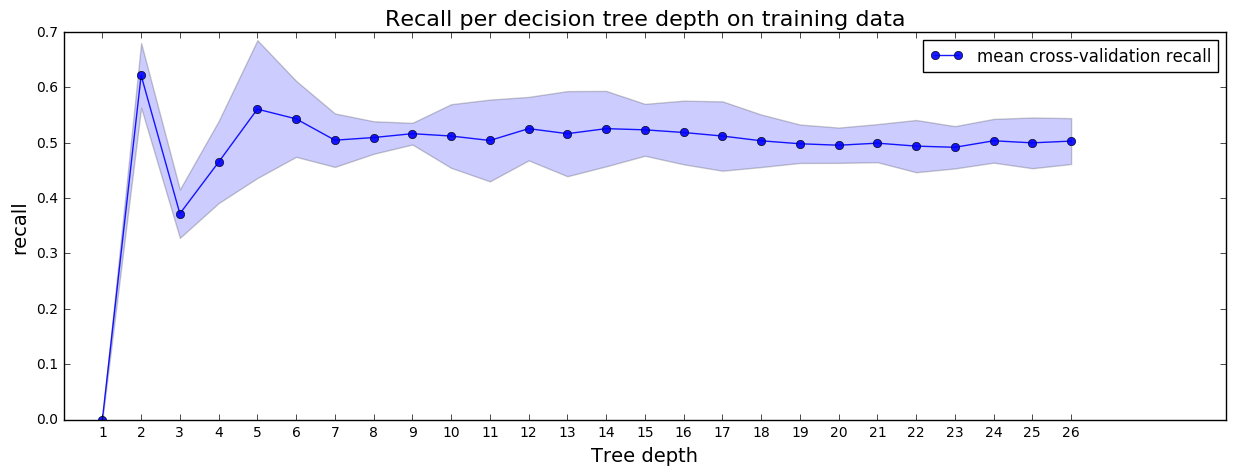

In [23]:
plt.show()

从上图可以得知，max_depth = 2 可以得到最好的recall score。所以下面的模型我们会把max_depth选为 2。

In [24]:
train,test = train_test_split(df,test_size = .3 ,random_state = 111)

features_train = train[feature_col_list]
labels_train = train['Churn_Label']

features_test = test[feature_col_list]
labels_test = test['Churn_Label']

In [25]:
clf = tree.DecisionTreeClassifier(max_depth = 2)
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

In [26]:
print (classification_report(labels_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1589
           1       0.50      0.61      0.55       524

    accuracy                           0.75      2113
   macro avg       0.68      0.71      0.69      2113
weighted avg       0.77      0.75      0.76      2113



这个模型能找出所有流失客户里的61%，模型认为的流失用户里有一半确实是流失用户。 

下面来看一下模型用了哪些feature来分裂决策树。

In [27]:
clf.feature_importances_

array([0.        , 0.02623758, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.23560231, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.7381601 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [28]:
for feat, importance in zip(features_train.columns, clf.feature_importances_):
    if importance > 0:
        print ('feature: {f}, importance: {i}'.format(f=feat, i=importance))

feature: MonthlyCharges, importance: 0.0262375834553874
feature: InternetService_Fiber optic, importance: 0.2356023129777826
feature: Contract_Month-to-month, importance: 0.7381601035668299


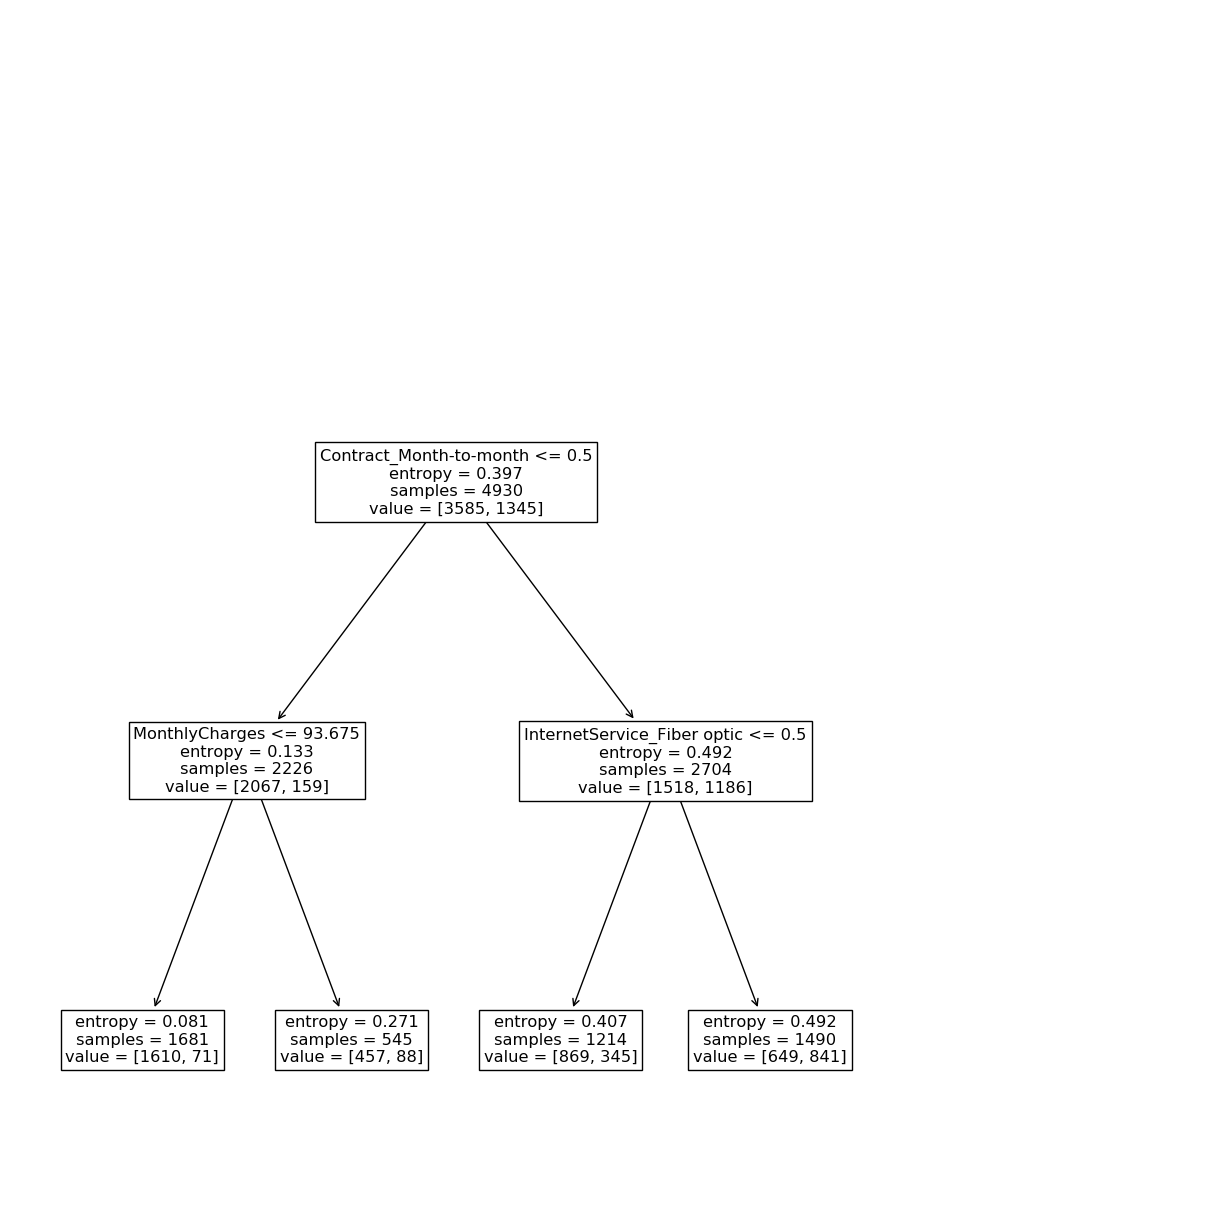

In [29]:
fig, axes = plt.subplots(figsize = (15,15))

tree.plot_tree(clf, feature_names = feature_col_list)
                              
plt.show()

从上面图可知，签了"month-to-month"合约的客户比一次性签了1年或2年的客户更容易流失，这在业务理解上也容易说得通。

当然从上图还获知，尽管客户签了1年或2年的合约，但如果发现每个月的花费超过94美元，也容易成为流失客户。由此可以推测，对待长时间合同的客户，我们可以考虑从性价比入手来提高留存率，比如推出94美元内的各种套餐组合。如果长合约用户的花费有超过94美元的可能，立马推荐他们其他更高性价比的套餐。

同时我们还发现，对于签了“month-to-month”的这批用户，如果他们同时还签了"Fiber optic"的上网服务，那么这批客户有很大可能性会被流失掉。虽然签月合同的客户本来就容易流失，但叠加的“Fiber optic”上网服务看起来让情况变得更糟。需要做市场调查和问卷调查了解清楚“Fiber optic”上网服务是不是存在问题，可从定价，网速，竞争对手作为入手点。在调查清楚之前，尽量不要让客服和销售人员推荐“Fiber optic”上网服务给月合同客户。

所以总结来说，为了提高留存率，我们更鼓励客户签长时间合同，如果客户愿意签长时间，那么我们要注意监控客户的月消费情况，尽量推荐高性价比的服务给他们；如果客户还是想尝试月合同，那么我们要在现阶段避免他们选择"Fiber optic"的上网服务。

面对可能存在correlated variables， 决策树可以用feature importance（基于information gain或者gini）去提取其中任意一个，剩下的variables则会有比较低的feature importance（因为很多可被提取的information已经涵盖在被提取的那个feature里），尽管这批variables的每一个都和target variable有着很相似的关联。所以我们经常认为coreelated issues对决策树在learning和overfitting上基本无影响。但是在数据的理解上面可能会存在问题，比如上面的contractor-month-to-month是feature importance最高的分叉点，但又因为contractor-month-to-month和其他varibale有很高的关联性，所以我们想剔除contactor-month-to-month来看一下决策树。

从上面correlation matrix图可知与Contract_month-to-month有比较强的correlation variables有 tenur 和 TotalCharges.

下面我们把 Contract_month-to-month 从可选features里删除，来观察是否决策树会选择tenure 或者 TotalCharges作为分叉点。

In [30]:
# 除去Contractor_month-to-month的所有feature列
feature_col_list = ['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Label',
       'SeniorCitizen_Label', 'Partner_Label', 'Dependents_Label',
       'PhoneService_Label', 'MultipleLines_Label', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_Label', 'OnlineBackup_Label',
       'DeviceProtection_Label', 'TechSupport_Label', 'StreamingTV_Label',
       'StreamingMovies_Label', #'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Label',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

In [31]:
train,test = train_test_split(df,test_size = .3 ,random_state = 111)

features_train = train[feature_col_list]
labels_train = train['Churn_Label']

features_test = test[feature_col_list]
labels_test = test['Churn_Label']

clf_1 = tree.DecisionTreeClassifier(max_depth = 2)
clf_1 = clf_1.fit(features_train, labels_train)
pred_1 = clf_1.predict(features_test)

print (classification_report(labels_test, pred_1))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1589
           1       0.63      0.38      0.48       524

    accuracy                           0.79      2113
   macro avg       0.73      0.65      0.67      2113
weighted avg       0.77      0.79      0.77      2113



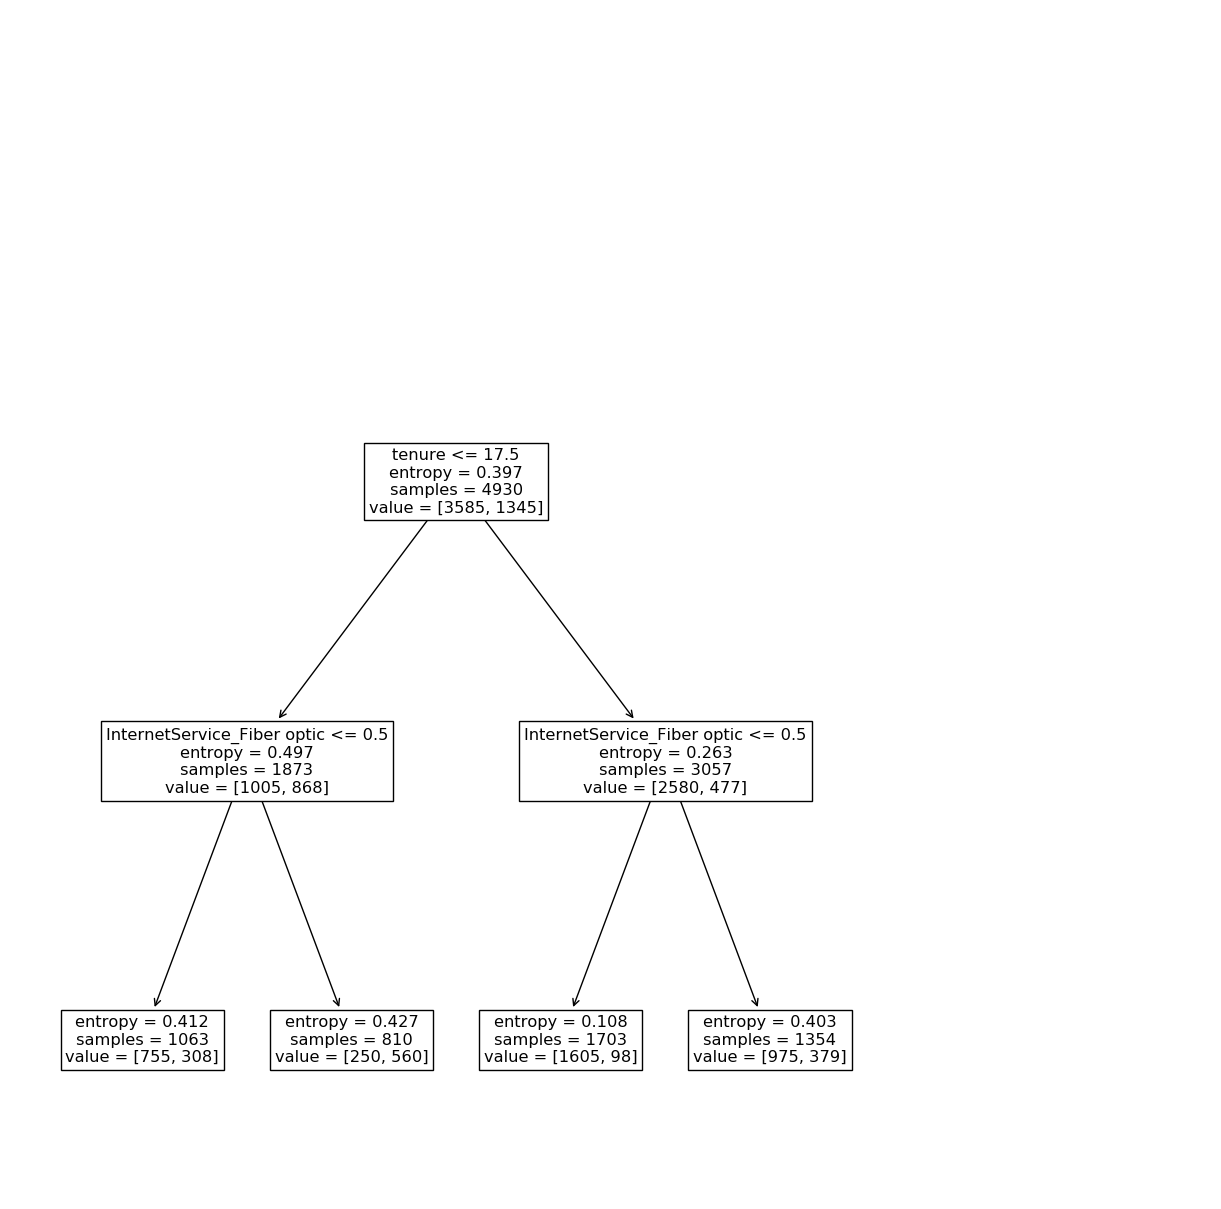

In [32]:
fig, axes = plt.subplots(figsize = (15,15))

tree.plot_tree(clf_1, feature_names = feature_col_list)
                              
plt.show()

当去除"Contractor_month-to-month"这个特征后，决策树果然选择了和"Contractor_month-to-month"有很高correlation的 tenure 作为最高分叉点。同时也再次验证了选择"fiber optic"的用户更容易被流失掉，其中短期+"fiber optic"的组合让留存率更低。

下面我们看看同时剔除"Contractor_month-to-month"和"tenure"两个feature后，totalcharges是否会成为决策树的重要分叉点。

In [33]:
# 除去Contractor_month-to-month和tenure的所有feature列
feature_col_list = [#'tenure', 
        'MonthlyCharges', 'TotalCharges', 'gender_Label',
       'SeniorCitizen_Label', 'Partner_Label', 'Dependents_Label',
       'PhoneService_Label', 'MultipleLines_Label', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_Label', 'OnlineBackup_Label',
       'DeviceProtection_Label', 'TechSupport_Label', 'StreamingTV_Label',
       'StreamingMovies_Label', #'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Label',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

In [34]:
train,test = train_test_split(df,test_size = .3 ,random_state = 111)

features_train = train[feature_col_list]
labels_train = train['Churn_Label']

features_test = test[feature_col_list]
labels_test = test['Churn_Label']

clf_2 = tree.DecisionTreeClassifier(max_depth = 2)
clf_2 = clf_2.fit(features_train, labels_train)
pred_2 = clf_2.predict(features_test)

print (classification_report(labels_test, pred_2))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1589
           1       0.63      0.39      0.48       524

    accuracy                           0.79      2113
   macro avg       0.72      0.66      0.67      2113
weighted avg       0.77      0.79      0.77      2113



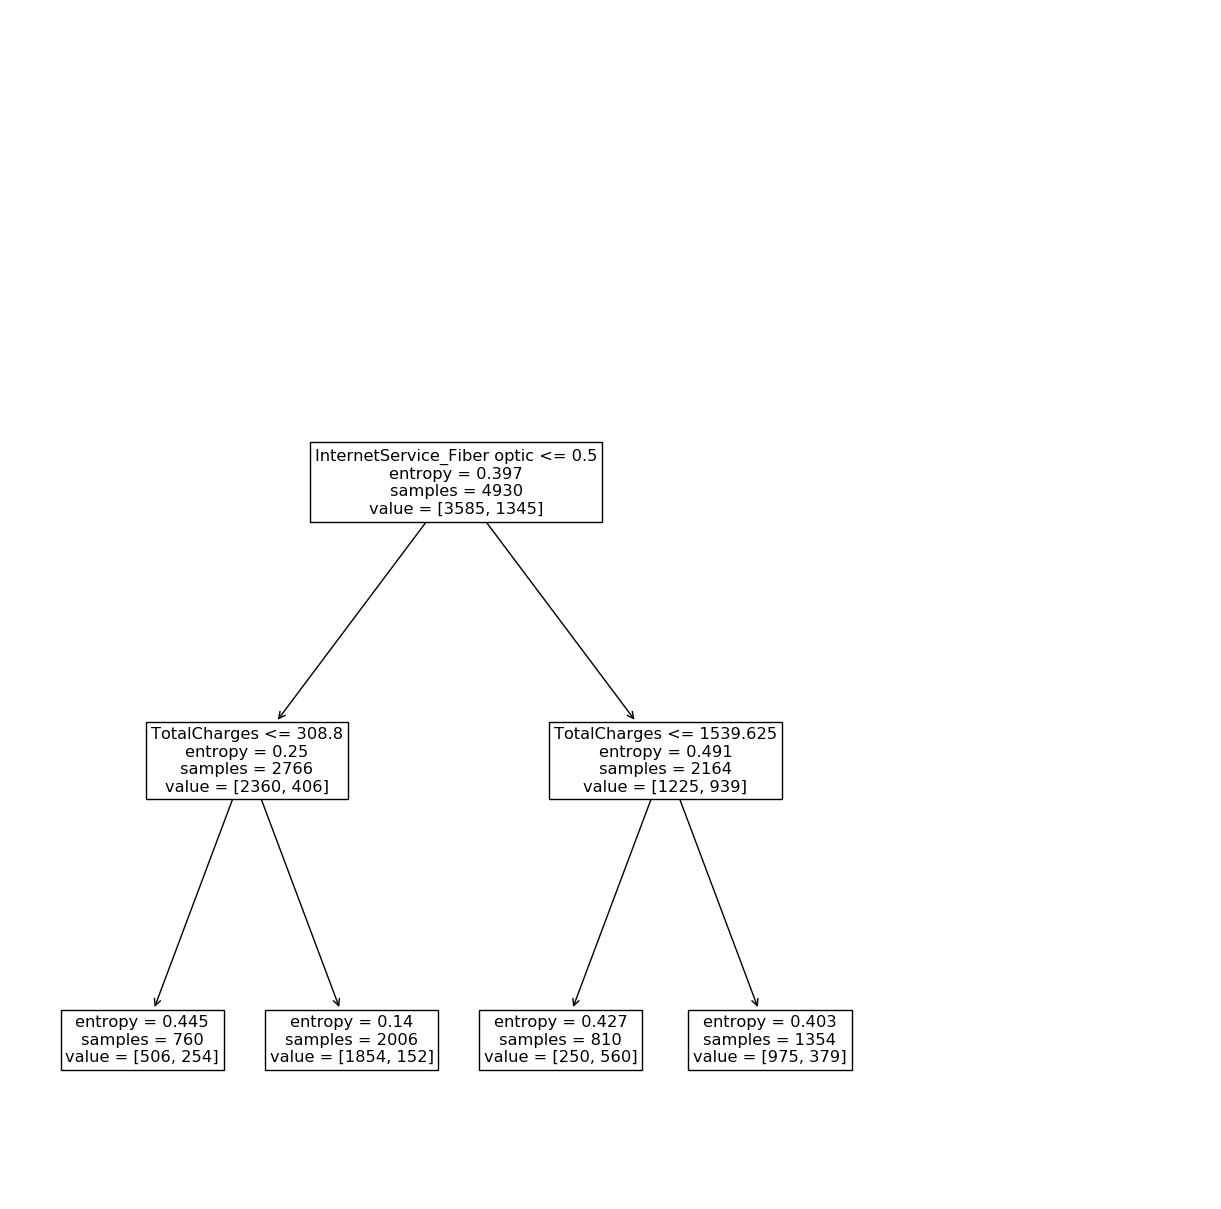

In [35]:
fig, axes = plt.subplots(figsize = (15,15))

tree.plot_tree(clf_2, feature_names = feature_col_list)
                              
plt.show()

同时剔除"Contractor_month-to-month"和"tenure"两个feature后，totalcharges也成为了重要分叉点。上面的决策树图再次验证了fiber_optic的服务和用户流失有比较强的关联性。

TotalCharges小于308.8看上去也很容易流失，可能和用户累计使用时长有关，再次佐证了时长对用户流失的影响。

比较需要注意的是，totoalcharges作为第二层的两个分叉点，选没选“fiber_optic”服务的分叉数差距很大：308.8 与 1539.625， 因此我们可以提出一个比较合理的假设，可能“fiber_optic”服务的高价格会影响客户的流失。

同时还有一个很有意思的发现，选了“fiber_optic”服务且totalcharges超过1539后，用户反而没有那么容易流失掉，这可能说明“fiber_optic”服务还是有一些客户认可，且愿意花很多钱来购买这项服务。

所以结合上面两点，我们可以推论出一个猜想：“fiber_optic”服务价格比较高，但可能因为有一些很棒的吸引点，所以有些顾客短期内还是会选择这项服务，但过了一段时间发现可能这项服务并不适合他们，再加上这项服务的高昂价格，于是他们干脆就彻底离开了我们公司成为流失客户；但如果客户发现这项服务非常符合他们的日常应用，尽管价格比较高，顾客还是愿意为这项服务买单。从业务层面来讲，我们可以追踪参加了这项服务的客户使用这项服务的频率和平均时间，如果某些顾客的频率和平均使用时间不高，那么我们立马让销售和客服人员联系他们主动建议取消这项服务。

# 所以综合以上所有的决策树，有以下几点业务建议：

## 1. 尽量鼓励用户签超过一年的合约

## 2. 对于愿意签约超过一年的客户，考虑从性价比入手来提高留存率，比如推出94美元内的各种套餐组合。监控长合约用户的每月花费，如果有超过94美元的趋势，立马让销售人员主动联系他们并推荐可选的其他更高性价比套餐。

## 3. 理智地让客服和销售人员推荐这种价格高昂的“Fiber optic”上网服务给月合同客户，并对选择了“Fiber optic”上网服务但流失掉的短期客户进行深入用户调查，可从价格、服务、竞争对手着手

## 4. 对比长时间喜爱“Fiber optic”上网服务的用户和订阅“Fiber optic”上网服务后流失的用户，找出在使用这项服务上的区别有哪些，比如平均每日使用频率和平均使用时长。所以对于其他选择了“Fiber optic”上网服务的用户，追踪他们使用这项服务的平均每日使用频率和平均每日使用时长，一旦发现这两项指标偏低，立马让销售和客服人员联系他们主动建议取消这项服务。



# 业务可视化的角度分析完了，下面建立更精准的流失用户辨认模型

这次的模型选择主要基于features的2个条件：

1. 含有大量的categorial variables（虽然也被转换为1和0的numeric了，但本质上还是categorical）及3个numeric variables（tenure, monthlycharge和totalcharge）

2. 部分features之间有比较强的correlation

综上，选择了random forest模型。

# random forest

鉴于random forest的feature importance可能会降低correlated variables的importance，所以特征工程部分分别用了random forest和Recursive Feature Elimination (依然是用Random Forest做RFE) 来对比feature selection，从而看是否这两种特征选择会有区别，以及如果有区别，对random forest模型是否有影响。

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

In [37]:
# 提出所有feature列
feature_col_list = ['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Label',
       'SeniorCitizen_Label', 'Partner_Label', 'Dependents_Label',
       'PhoneService_Label', 'MultipleLines_Label', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_Label', 'OnlineBackup_Label',
       'DeviceProtection_Label', 'TechSupport_Label', 'StreamingTV_Label',
       'StreamingMovies_Label', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Label',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

In [38]:
train,test = train_test_split(df,test_size = .3 ,random_state = 111)

features_train = train[feature_col_list]
labels_train = train['Churn_Label']

features_test = test[feature_col_list]
labels_test = test['Churn_Label']

In [39]:
def go_random_forest(X_train, Y_train, X_test, Y_test):
    rf = RandomForestClassifier(n_estimators=40)
    rf.fit(X_train, Y_train)
    pred = rf.predict(X_test)
    
    print (classification_report(Y_test, pred))
    
    

## 用random forest直接选取features

In [40]:
sel = SelectFromModel(RandomForestClassifier(n_estimators=40))
sel.fit(features_train,labels_train )
sel.get_support()

array([ True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False])

查看哪些featue被选取了：

In [41]:
features_rf = features_train.columns[sel.get_support()]
features_rf

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'Contract_Month-to-month'], dtype='object')

用random forest直接选取的features,在random forest模型里的效果：

In [42]:
go_random_forest(sel.transform(features_train), labels_train, sel.transform(features_test), labels_test)

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1589
           1       0.53      0.48      0.50       524

    accuracy                           0.77      2113
   macro avg       0.68      0.67      0.68      2113
weighted avg       0.76      0.77      0.76      2113



## 用 RFE + random forest 选取features

In [43]:
sel = RFE(RandomForestClassifier(n_estimators=40),  n_features_to_select=10)
sel.fit(features_train,labels_train )
sel.get_support()



array([ True,  True,  True,  True, False,  True, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
        True, False, False,  True, False, False,  True, False])

查看哪些featue被选取了：

In [44]:
features_rfe = features_train.columns[sel.get_support()]
features_rfe

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Label',
       'Partner_Label', 'InternetService_Fiber optic', 'OnlineSecurity_Label',
       'Contract_Month-to-month', 'PaperlessBilling_Label',
       'PaymentMethod_Electronic check'],
      dtype='object')

用 RFE + random forest 选取的features,在random forest模型里的效果：

In [45]:
go_random_forest(sel.transform(features_train), labels_train, sel.transform(features_test), labels_test) # 40, 10

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1589
           1       0.57      0.51      0.54       524

    accuracy                           0.78      2113
   macro avg       0.71      0.69      0.70      2113
weighted avg       0.78      0.78      0.78      2113



通过对比发现，用 RFE + random forest 选取的features 优于 用random forest直接选取的features.

## 接下来，对下面组合进行网格调参，以达到最好的训练效果：
## 特征工程： RFE + random forest， 模型：random forest 


In [46]:
from sklearn.model_selection import GridSearchCV

sel = RFE(RandomForestClassifier(n_estimators=40),  n_features_to_select=10)
sel.fit(features_train,labels_train )

features_train = sel.transform(features_train)
features_test = sel.transform(features_test)

classifier = RandomForestClassifier()

param_grid = { 
    'n_estimators':  range(10,50),
    
    'criterion': ['gini','entropy'],
    'max_depth':range(2,15)
    
    
}

CV_rfc = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring='f1')
CV_rfc.fit(features_train, labels_train)
print (CV_rfc.best_params_)

C:\Users\youfe\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



{'n_estimators': 26, 'criterion': 'entropy', 'max_depth': 8}


In [47]:
pred =CV_rfc.predict(features_test)
print (classification_report(labels_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1589
           1       0.62      0.54      0.58       524

    accuracy                           0.81      2113
   macro avg       0.74      0.72      0.73      2113
weighted avg       0.80      0.81      0.80      2113



# Limitations:

1. 建立模型前的EDA只做了correlation matrix

2. 在random forest模型结束后，其实还有快速尝试其他模型，比如SVM（没有调参），但因为效果没有比random forest更好，所以没有写出来。